In [ ]:
#!pip uninstall tensorflow


Uninstalling tensorflow-2.2.0rc1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.2.0rc1


In [ ]:

#!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 77.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c594895dd0ff014344f7da52ad401c1d7e701527c506b77b9663f6b7d834db7c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
tf.__version__

'2.4.1'

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [6]:
train_images.dtype

dtype('uint8')

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28).astype('float32')

In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
train_images = (train_images -127.5)/127.5

In [10]:
BATTH_SIZE = 256
BUFFER_SIZE = 60000

In [11]:
datasets = tf.data.Dataset.from_tensor_slices(train_images)

In [12]:
datasets = datasets.shuffle(BUFFER_SIZE).batch(BATTH_SIZE)

In [13]:
datasets

<BatchDataset shapes: (None, 28, 28), types: tf.float32>

In [16]:
def generator_model():
  model = keras.Sequential()
  model.add(layers.Dense(256,input_shape=(100,), use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(512, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(28*28*1, use_bias=False, activation='tanh'))
  model.add(layers.BatchNormalization())
  
  model.add(layers.Reshape((28, 28, 1)))

  return model

In [17]:
def discriminator_model():
  model = keras.Sequential()
  model.add(layers.Flatten())

  model.add(layers.Dense(512, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(256, use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(1))

  return model

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real_out, fake_out):
  read_loss = cross_entropy(tf.ones_like(real_out), real_out)
  fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
  return read_loss + fake_loss

In [20]:
def generator_loss(fake_out):
  return cross_entropy(tf.ones_like(fake_out), fake_out)

In [21]:
generator_opt = tf.keras.optimizers.Adam(1e-4)
discriminator_opt = tf.keras.optimizers.Adam(1e-4)

In [22]:
EPOCHS = 200
noise_dim = 100

In [23]:
num_exp_to_generate = 16

In [24]:
seed = tf.random.normal([num_exp_to_generate, noise_dim])

In [25]:
generator = generator_model()

In [26]:
discriminator = discriminator_model()

In [27]:
def train_step(images):
  noise = tf.random.normal([BATTH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    real_out = discriminator(images, training=True)

    gen_image = generator(noise, training=True)
    fake_out = discriminator(gen_image, training=True)

    gen_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out)

  gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_opt.apply_gradients(zip(gradient_gen, generator.trainable_variables))
  discriminator_opt.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))

In [29]:
def generate_plot_image(gen_model,test_noise):
  pre_images = gen_model(test_noise, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range (pre_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow((pre_images[i, :, :, 0] +1)/2, cmap='gray')
    plt.axis('off')
  plt.show()

In [30]:
def train(dataset, epochs):
  for epoch in range (epochs):
    for image_batch in dataset:
      train_step(image_batch)
      print('.', end='')
    generate_plot_image(generator,seed)

...........................................................................................................................................................................................................................................

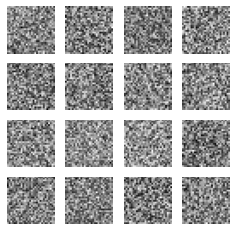

...........................................................................................................................................................................................................................................

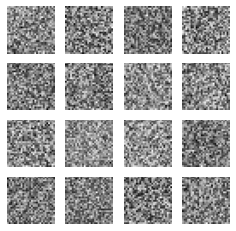

...........................................................................................................................................................................................................................................

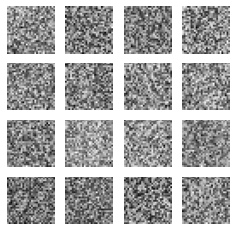

...........................................................................................................................................................................................................................................

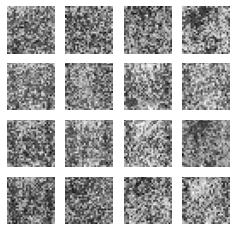

...........................................................................................................................................................................................................................................

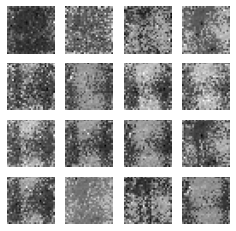

...........................................................................................................................................................................................................................................

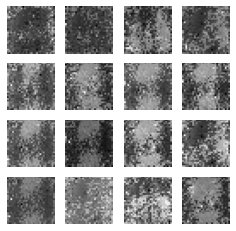

...........................................................................................................................................................................................................................................

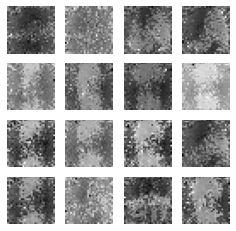

...........................................................................................................................................................................................................................................

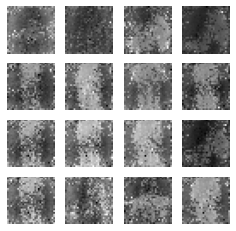

...........................................................................................................................................................................................................................................

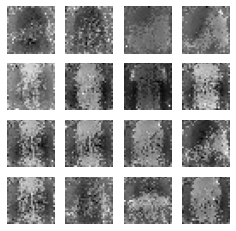

...........................................................................................................................................................................................................................................

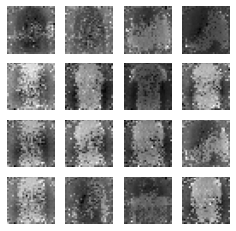

...........................

In [ ]:
train (datasets, EPOCHS)